Capital Asset Pricing Model
* $E(R_i) = R_f+B_i(E(R_m)-R_f)$
 * $E(R_i)$ - expected return in stock
 * $E(R_f)$ - risk-free rate
 * $E(R_m)$ - expected market return
 * $R_m - R_f$ - market risk premium
 * $B_i$ - measure of stock's market risk or sensitivity
   * Beta: $B_i = \frac{Cov(R_i, R_m)}{Var(R_m)} = \rho_{i,m}\frac{\sigma_{i}}{\sigma_m}$

* Relationship between the excess stock returns and the excess market returns:
 * $R_i-R_f = a+B_i(R_m-R_f)$

* Portfolio Beta: $B$ = $\sum_{i=1}^{n}$$w_iB_i$
 * $w_i$ = $\frac{v_i}{\sum_{i=1}^{n}
v_i}$
 * $v_i$ - Portfolio's value of stock $i$

Arbitrage Pricing Theory
* $E(R_i) = a_i + B_{i,1}F_1+B_{i,2}F_2+B_{i,j}F_j$
 * $R_i$ - expected rate of return on security $i$
 * $α_i$ - alpha (unsystematic risk); expected return on stock $i$ for factors that are negligible (implies no sensitivity to the market)
 * $β_{i,j}$ - beta (systematic or market risk); sensitivity of the $i$th asset to the $j$th factor
 * $F_j$ - value of the $j$th factor that influences the return on stock $i$
 * A perfect portfolio would have a Beta close to zero with a very large positive alpha.

In [ ]:
!pip install yfinance

In [ ]:
!pip install pulp

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yfinance as yf
import scipy as sp
from scipy import stats
import statsmodels.formula.api as sm
import statsmodels.stats.stattools as tools
from scipy.stats import probplot
import pylab
import pulp

In [4]:
today = datetime.today()
days = timedelta(days=5000)
start = today-days

In [5]:
print('start:', start, '\t', 'end:', today)

start: 2008-11-14 19:40:12.931439 	 end: 2022-07-24 19:40:12.931439


In [ ]:
aapl = yf.download('AAPL', start, today)
amzn = yf.download('AMZN', start, today)
ge = yf.download('GE', start, today)
SP500 = yf.download('^GSPC', start, today) # S&P 500 ticker

In [7]:
aapl = aapl['Adj Close']
aapl = aapl.pct_change(1)
aapl.dropna(inplace=True)

amzn = amzn['Adj Close']
amzn = amzn.pct_change(1)
amzn.dropna(inplace=True)

ge = ge['Adj Close']
ge = ge.pct_change(1)
ge.dropna(inplace=True)

SP500 = SP500['Adj Close']
SP500 = SP500.pct_change(1)
SP500.dropna(inplace=True)

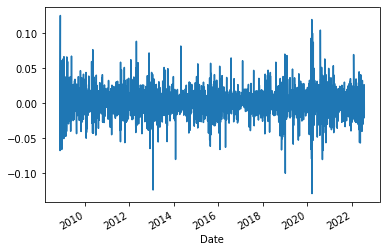

In [8]:
# plot of AAPL returns
aapl.plot()

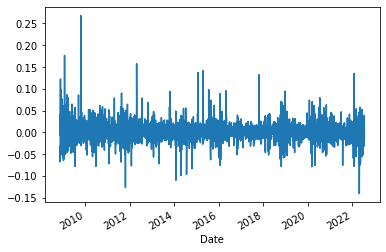

In [9]:
# plot of AMZN returns
amzn.plot()

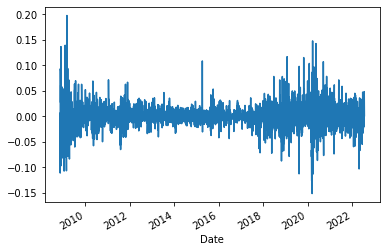

In [10]:
# plot of GE returns
ge.plot()

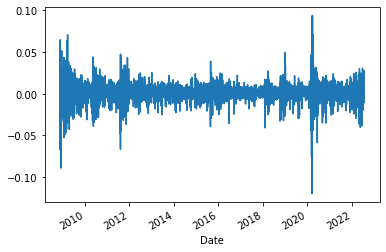

In [11]:
# plot of SP500 returns
SP500.plot()

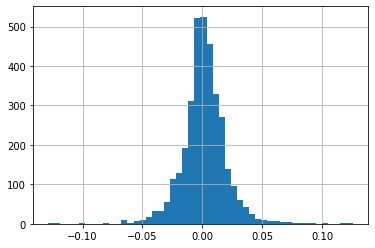

In [16]:
# Distribution plots of AAPL returns
aapl.hist(bins=50)

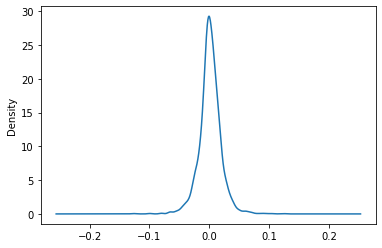

In [14]:
aapl.plot.density()

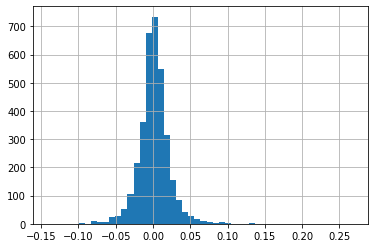

In [17]:
# Distribution plots of AMZN returns
amzn.hist(bins=50)

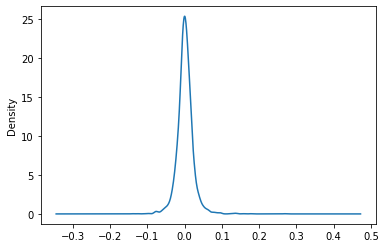

In [18]:
amzn.plot.density()

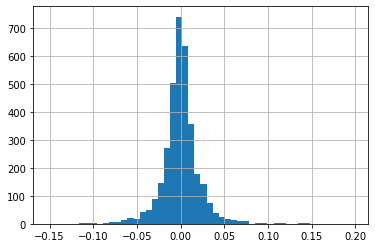

In [19]:
# Distribution plot of GE returns
ge.hist(bins=50)

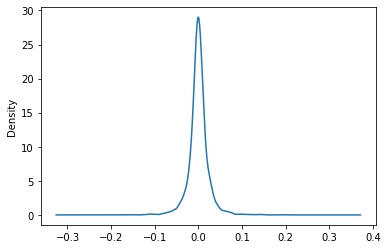

In [20]:
ge.plot.density()

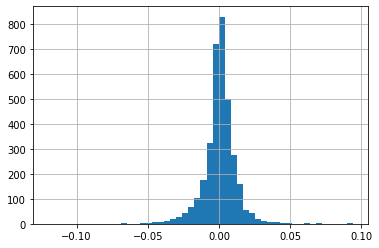

In [21]:
# Distribution plot of SP500 returns
SP500.hist(bins=50)

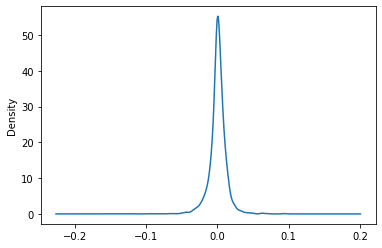

In [22]:
SP500.plot.density()

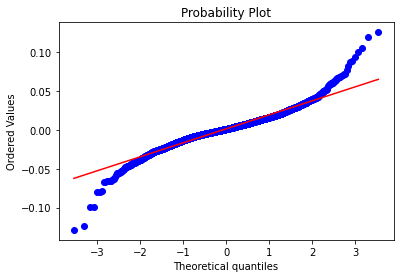

In [23]:
# QQPlot of AAPL returns
stats.probplot(aapl, dist="norm", plot=pylab)
pylab.show()

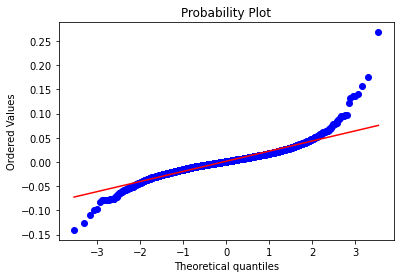

In [24]:
# QQPlot of AMZN returns
stats.probplot(amzn, dist="norm", plot=pylab)
pylab.show()

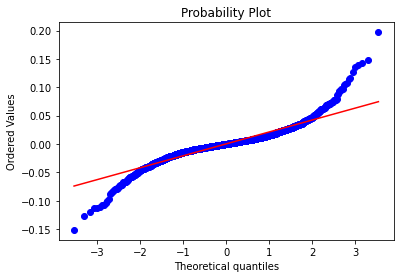

In [25]:
# QQPlot of GE returns
stats.probplot(ge, dist="norm", plot=pylab)
pylab.show()

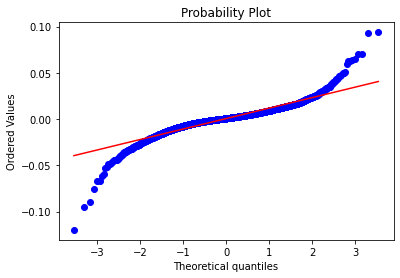

In [26]:
# QQPlot of SP500 returns
stats.probplot(SP500, dist="norm", plot=pylab)
pylab.show()

In [28]:
(aapl_beta,aapl_alpha,aapl_r_value,aapl_p_value,apple_std_err)=stats.linregress(SP500,aapl)
print(f"Apple Beta: {aapl_beta}, Apple Alpha: {aapl_alpha}")
print("R-squared=", aapl_r_value**2)
print("p-value =", aapl_p_value)
print("standard error", apple_std_err)

Apple Beta: 1.0446768264164499, Apple Alpha: 0.0008050407313995062
R-squared= 0.46382467154273527
p-value = 0.0
standard error 0.01914767798500281


In [29]:
(amzn_beta,amzn_alpha,amzn_r_value,amzn_p_value,amzn_std_err)=stats.linregress(SP500,amzn)
print(f"Amazon Beta: {amzn_beta}, Amazon Alpha: {amzn_alpha}")
print("R-squared=", amzn_r_value**2)
print("p-value =", amzn_p_value)
print("standard error", amzn_std_err)

Amazon Beta: 1.0327281784444677, Amazon Alpha: 0.0008926895728059633
R-squared= 0.3206819104646613
p-value = 2.89846172982024e-291
standard error 0.025623771298947707


In [30]:
(ge_beta,ge_alpha,ge_r_value,ge_p_value,ge_std_err)=stats.linregress(SP500,ge)
print(f"GE Beta: {ge_beta}, GE Alpha: {ge_alpha}")
print("R-squared=", ge_r_value**2)
print("p-value =", ge_p_value)
print("standard error", ge_std_err)

# GE has a larger beta and negative alpha
# This indicates that the risk of GE is higher compared to the market AND yields less returns than the sp500

GE Beta: 1.1995595766607314, GE Alpha: -0.0004317290162771418
R-squared= 0.423702573251757
p-value = 0.0
standard error 0.02384911541819999


# CAPM Class

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# market interest rate
RISK_FREE_RATE = 0.05
# considers monthly returns and calculates the annual return
MONTHS_IN_YEAR = 12

class CAPM:

    def __init__(self, stocks, start_date, end_date):
        self.data = None
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        data = {}

        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            data[stock] = ticker['Adj Close']

        return pd.DataFrame(data)

    def initialize(self):
        stock_data = self.download_data()
        # we use monthly returns instead of daily returns
        stock_data = stock_data.resample('M').last()

        self.data = pd.DataFrame({'s_adjclose': stock_data[self.stocks[0]],
                                  'm_adjclose': stock_data[self.stocks[1]]})

        # logarithmic monthly returns
        self.data[['s_returns', 'm_returns']] = np.log(self.data[['s_adjclose', 'm_adjclose']] /
                                                       self.data[['s_adjclose', 'm_adjclose']].shift(1))

        # remove the NaN values
        self.data = self.data[1:]

    def calculate_beta(self):
        # covariance matrix: the diagonal items are the variances
        # off diagonals are the covariances
        # the matrix is symmetric: cov[0,1] = cov[1,0] !!!
        covariance_matrix = np.cov(self.data["s_returns"], self.data["m_returns"])
        # calculating beta according to the formula
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]
        print("Beta from formula: ", beta)

    def regression(self):
        # using linear regression to fit a line to the data
        # [stock_returns, market_returns] - slope is the beta
        beta, alpha = np.polyfit(self.data['m_returns'], self.data['s_returns'], deg=1)
        print("Beta from regression: ", beta)
        print("Alpha from regression: ", alpha)
        # calculate the expected return according to the CAPM formula
        # we are after annual return (this is why multiply by 12)
        expected_return = RISK_FREE_RATE + beta * (self.data['m_returns'].mean()*MONTHS_IN_YEAR
                                                   - RISK_FREE_RATE)
        print("Expected return: ", expected_return)
        self.plot_regression(alpha, beta)

    def plot_regression(self, alpha, beta):
        fig, axis = plt.subplots(1, figsize=(20, 10))
        axis.scatter(self.data["m_returns"], self.data['s_returns'],
                     label="Data Points")
        axis.plot(self.data["m_returns"], beta * self.data["m_returns"] + alpha,
                  color='red', label="CAPM Line")
        plt.title('Capital Asset Pricing Model, finding alpha and beta')
        plt.xlabel('Market return $R_m$', fontsize=18)
        plt.ylabel('Stock return $R_a$')
        plt.text(0.08, 0.05, r'$R_a = \beta * R_m + \alpha$', fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Beta from formula:  0.9683952042695065
Beta from regression:  0.9683952042695062
Alpha from regression:  0.015913168564088472
Expected return:  0.10688985835297829


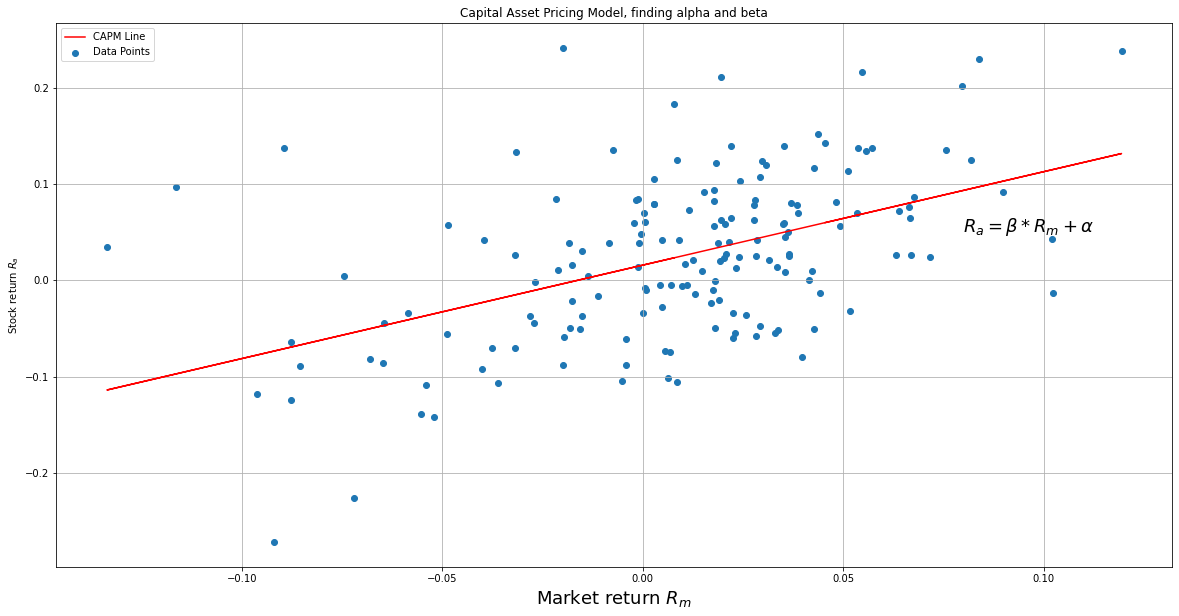

In [32]:
if __name__ == '__main__':
    capm = CAPM(['AMZN', '^GSPC'], start, today)
    capm.initialize()
    capm.calculate_beta()
    capm.regression()

# Portfolio optimization example 1
This example problem involves investing in two securities, X and Y, to find the actual number of units to invest for every three units of the security X and two units of the security Y, such that the total number of units invested is maximized.
* Certain constraints:
 * For every 2 units of the security X invested and 1 unit of the security Y invested, the total volume must not exceed 100
 * For every unit of the securities X and Y invested, the total volume must not exceed 80
 * The total volume allowed to invest in the security X must not exceed 40
 * Short-selling is not allowed for securities

* Maximize: $f(x,y) = 3x + 2y$
 * Subject to: 
  > $2x+y \le 100$
  > $x+y \le 80$
  > $x \le 40$
  > $x>0$, $y>0$

In [33]:
""" 
A simple linear optimization problem with 2 variables 
"""
x = pulp.LpVariable('x', lowBound=0)
y = pulp.LpVariable('y', lowBound=0)
    
problem = pulp.LpProblem(
        'A simple maximization objective', 
        pulp.LpMaximize)
problem += 3*x + 2*y, 'The objective function'
problem += 2*x + y <= 100, '1st constraint'
problem += x + y <= 80, '2nd constraint'
problem += x <= 40, '3rd constraint'
problem.solve()

/usr/local/lib/python3.7/dist-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


1

In [34]:
print("Maximization Results:")
for variable in problem.variables():
   print(variable.name, '=', variable.varValue)

Maximization Results:
x = 20.0
y = 60.0


# Portfolio optimization example 2

Suppose we would like to build a portfolio that consists of three securities: a, b, and c. The allocation of the portfolio must meet certain constraints: it must consist of six units of a long position in the security a. With every two units of the security a, one unit of the security b, and one unit of the security c invested, the net position must be long four units. With every one unit of the security a, three units of the security b, and two units of the security c invested, the net position must be long five units.

To find out the number of securities to invest in, we can frame the problem mathematically, as follows:
* $2a + b + c = 4$
* $a + 3b + 2c = 5$
* $a = 1$

$A = \left[\begin{array}{ccc} 2&1&1\\ 1&3&2\\ 1&0&0 \end{array}\right]$

$x = \left[\begin{array}{c} a\\ b\\c\end{array}\right]$

$B = \left[\begin{array}{c} 4\\ 5\\6\end{array}\right]$

$Ax = B$

To solve for the x vector that contains the number of securities to invest in, the inverse of the A matrix is taken and the equation is written as follows:

$x =A^{-1}B$

In [35]:
import numpy as np
A = np.array([[2, 1, 1],[1, 3, 2],[1, 0, 0]])
B = np.array([4, 5, 6])

In [36]:
print(np.linalg.solve(A, B))

[  6.  15. -23.]


This portfolio would require long positions of 6 units of security a and 15 units of security b, and a short position of 23 units of security c.

In [37]:

""" 
LU decomposition with SciPy 
"""
import numpy as np
import scipy.linalg as linalg

# Define A and B
A = np.array([
    [2., 1., 1.],
    [1., 3., 2.],
    [1., 0., 0.]])
B = np.array([4., 5., 6.])

# Perform LU decomposition
LU = linalg.lu_factor(A)
x = linalg.lu_solve(LU, B)
print(x)

[  6.  15. -23.]
